# Fine-tune BLIP using Hugging Face `transformers` and `datasets` 🤗

This tutorial is largely based from the [GiT tutorial](https://colab.research.google.com/drive/1HLxgrG7xZJ9FvXckNG61J72FkyrbqKAA?usp=sharing) on how to fine-tune GiT on a custom image captioning dataset. Here we will use a dummy dataset of [football players](https://huggingface.co/datasets/ybelkada/football-dataset) ⚽ that is uploaded on the Hub. The images have been manually selected together with the captions. 
Check the 🤗 [documentation](https://huggingface.co/docs/datasets/image_dataset) on how to create and upload your own image-text dataset.

In [21]:
!pip install transformers==4.28.0 -q datasets rouge sacrebleu
!git config --global credential.helper store
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) Y
Token is valid.
Your token has been saved in your configured git cred

In [36]:
import random
import numpy as np
import pandas as pd
from sacrebleu.metrics import BLEU, CHRF
from transformers import AutoProcessor, AutoModelForCausalLM, TrainingArguments, BlipForConditionalGeneration, pipeline
from datasets import load_dataset, Dataset
from PIL import Image
import base64
import os
import io
os.environ["WANDB_DISABLED"] = "true"

# Import PyTorch
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor, transforms

# Import tqdm for progress bar
from tqdm.auto import tqdm

# Import matplotlib for visualization
from matplotlib import pyplot as plt
import plotly.express as px
from plotly.offline import init_notebook_mode

# Measure time
from timeit import default_timer as timer

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldnt' be lower than 0.11
print(f'PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}')


PyTorch version: 2.0.0+cu118
torchvision version: 0.15.1+cu118


In [25]:
dataset = load_dataset("agestau/preproc-fashion-products")
ds=dataset["train"]
dataset7 = ds.remove_columns(['subCategory'])
dataset7

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['image', 'text'],
    num_rows: 36145
})

In [26]:
dataset7[0]["text"]

'Men Navy Blue Shirt'

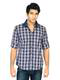

In [27]:
dataset7[0]["image"]

In [ ]:
# Sampling for testing
#dataset7_sample = dataset7.shuffle().select(range(100))
#dataset7_sample

Dataset({
    features: ['image', 'text'],
    num_rows: 100
})

In [28]:
dataset7 = dataset7.train_test_split(test_size=0.1)
train_ds = dataset7["train"]
test_ds = dataset7["test"]

#dataset7_sample = dataset7_sample.train_test_split(test_size=0.1)
#train_ds = dataset7_sample["train"]
#test_ds = dataset7_sample["test"]

In [30]:
class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        return encoding

In [ ]:
processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

In [31]:
train_dataset = ImageCaptioningDataset(train_ds, processor)
train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True)

test_dataset = ImageCaptioningDataset(test_ds, processor)
test_dataloader = DataLoader(test_dataset, batch_size=5, shuffle=True)

In [ ]:
sample_batch = next(iter(train_dataloader))
print(sample_batch)

In [32]:
# Creating a function to time our experiments

def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [33]:
# Function for training and testing loops

def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device):
    train_loss = 0
    model.train()

    for idx, batch in enumerate(data_loader):
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device)

        # 1. Forward pass
        outputs = model(input_ids=input_ids,
                        pixel_values=pixel_values,
                        labels=input_ids)
        loss = outputs.loss
        train_loss += loss.item()

        # 2. Optimizer zero grad
        optimizer.zero_grad()

        # 3. Loss backward
        loss.backward()

        # 4. Optimizer step
        optimizer.step()

        # Print loss per batch
        if (idx + 1) % 10 == 0:
          print(f"Batch {idx+1}/{len(data_loader)} - Loss: {loss:.5f}")

    # Calculate loss per epoch and print out
    train_loss /= len(data_loader)
    print(f"Train loss: {train_loss:.5f}")
    

In [34]:

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              device: torch.device = device):
    test_loss = 0
    model.eval()  # Put model in evaluation mode

    with torch.inference_mode():
        for idx, batch in enumerate(data_loader):
            input_ids = batch.pop("input_ids").to(device)
            pixel_values = batch.pop("pixel_values").to(device)

            # 1. Forward pass
            outputs = model(input_ids=input_ids,
                            pixel_values=pixel_values,
                            labels=input_ids)
            loss = outputs.loss
            test_loss += loss.item()

        # Calculate loss per epoch and print out
        test_loss /= len(data_loader)
        print(f"Test loss: {test_loss:.5f}\n")

In [35]:


torch.manual_seed(42)

def eval_model(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader):
  
    import logging
    import warnings
    logging.getLogger("transformers").setLevel(logging.ERROR)
    warnings.filterwarnings("ignore")

    bleu = BLEU()
    chrf = CHRF()

    model = model.to(device)
    model.eval()
    predictions = []
    references = []

    with torch.inference_mode():
        for idx, batch in enumerate(data_loader, start=1):
            input_ids = batch.pop("input_ids").to(device)
            pixel_values = batch.pop("pixel_values").to(device)

            outputs = model.generate(input_ids=input_ids,pixel_values=pixel_values,max_length=50)
            
            predicted_sentences_batch = processor.batch_decode(outputs, skip_special_tokens=True)
            predictions.extend(predicted_sentences_batch)
            
            reference_sentences_batch = [processor.decode(ids, skip_special_tokens=True) for ids in input_ids]
            references.extend(reference_sentences_batch)

            # Prints individual batch results for the batch
            if idx % 100 == 0:
                print(f"Batch {idx}:")
                print("predicted_sentences:")
                print(predicted_sentences_batch)
                print("reference_sentences:")
                print(reference_sentences_batch)
                print(type(reference_sentences_batch))
                print()

                # BLEU and CHRF scores for the current batch
                bleu_score = bleu.corpus_score(predicted_sentences_batch, [reference_sentences_batch])
                print(f"BLEU score for Batch {idx}: {bleu_score.score}")

                chrf_score = chrf.corpus_score(predicted_sentences_batch, [reference_sentences_batch])
                print(f"CHRF score for Batch {idx}: {chrf_score.score}")
                print()  # Print an empty line for readability
        
    return {"model_name": "Fine Tuned 'BlipForConditionalGeneration' for Fashion Items",
            "bleu_score": bleu.corpus_score(predictions, [references]).score,
            "chrf_score": chrf.corpus_score(predictions, [references]).score}

In [ ]:
def evaluate_model(model, data, device):
    model = model.to(device)
    predictions = []
    references = []

    # Prepare and plot the selected examples
    for i, example in enumerate(data):
        image = example["image"]
        real_caption = example["text"]
        references.append(real_caption.lower())

        inputs = processor(images=image, return_tensors="pt").to(device)
        pixel_values = inputs.pixel_values

        generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
        generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        predictions.append(" ".join(generated_caption.split()))

    print("reference_sentences:")
    print(references)
    print("predicted_sentences:")
    print(predictions)
    print()

    print("bleu_score: ", BLEU().corpus_score(predictions, [references]).score)
    print("chrf_score: ", CHRF().corpus_score(predictions, [references]).score)

In [ ]:
torch.manual_seed(42)

# Measure time
train_time_start = timer()

model.to(device)

# Train and test model 
epochs = 3
for epoch in tqdm(range(epochs)):
    #sample_data = next(iter(test_dataloader))
    #print(sample_data) 
    print(f"Epoch: {epoch}\n---------")
    train_step(model=model, 
          data_loader=train_dataloader,
          optimizer=optimizer,
          device=device
    )
    test_step(model=model,
         data_loader=test_dataloader,
         device=device
    )

train_time_end = timer()
total_train_time_cnn_model = print_train_time(start=train_time_start, 
                                              end=train_time_end,
                                              device=device)


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Batch 10/6506 - Loss: 10.19910
Batch 20/6506 - Loss: 8.69794
Batch 30/6506 - Loss: 7.18618
Batch 40/6506 - Loss: 5.77508
Batch 50/6506 - Loss: 4.37921
Batch 60/6506 - Loss: 3.10857
Batch 70/6506 - Loss: 2.10818
Batch 80/6506 - Loss: 1.63804
Batch 90/6506 - Loss: 1.49530
Batch 100/6506 - Loss: 1.42361
Batch 110/6506 - Loss: 1.40648
Batch 120/6506 - Loss: 1.42840
Batch 130/6506 - Loss: 1.38223
Batch 140/6506 - Loss: 1.40426
Batch 150/6506 - Loss: 1.38489
Batch 160/6506 - Loss: 1.39146
Batch 170/6506 - Loss: 1.39795
Batch 180/6506 - Loss: 1.39339
Batch 190/6506 - Loss: 1.39414
Batch 200/6506 - Loss: 1.36577
Batch 210/6506 - Loss: 1.37510
Batch 220/6506 - Loss: 1.37482
Batch 230/6506 - Loss: 1.37072
Batch 240/6506 - Loss: 1.36976
Batch 250/6506 - Loss: 1.38444
Batch 260/6506 - Loss: 1.38287
Batch 270/6506 - Loss: 1.38380
Batch 280/6506 - Loss: 1.38210
Batch 290/6506 - Loss: 1.38236
Batch 300/6506 - Loss: 1.36892
Batch 310/6506 - Loss: 1.38948
Batch 320/6506 - Loss: 1.377

In [ ]:
model.push_to_hub("f_cap_allrecs") # all recs - 32530 training; 3615 validation; batch_size=5; 3 Epochs

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/agestau/f_cap_allrecs/commit/381cc5193e527833ca89447a86a1f2aa817d87da', commit_message='Upload BlipForConditionalGeneration', commit_description='', oid='381cc5193e527833ca89447a86a1f2aa817d87da', pr_url=None, pr_revision=None, pr_num=None)

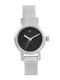

In [ ]:
# load image
example = dataset7["train"][1854]
image = example["image"]
image

In [ ]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

men black dial watch


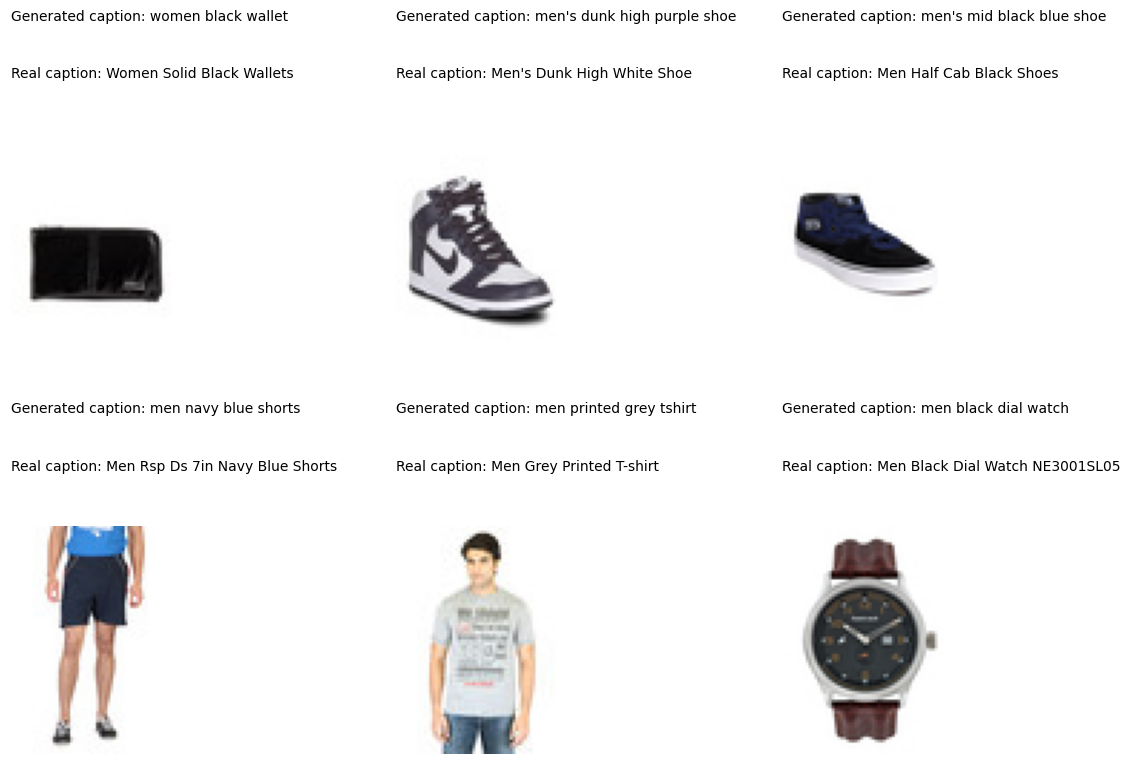

In [ ]:
fig = plt.figure(figsize=(12, 8))

# Convert dataset7 to a list and select 6 random examples
random_examples = random.sample(list(dataset7["train"]), 6)

# Prepare and plot the selected examples
for i, example in enumerate(random_examples):
    image = example["image"]
    real_caption = example["text"]

    inputs = processor(images=image, return_tensors="pt").to(device)
    pixel_values = inputs.pixel_values

    generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
    generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    ax = fig.add_subplot(2, 3, i+1)
    ax.imshow(image)
    ax.axis("off")
    ax.text(0, -20, f"Real caption: {real_caption}", fontsize=10, ha="left")
    ax.text(0, -40, f"Generated caption: {generated_caption}", fontsize=10, ha="left")

plt.tight_layout()
plt.show()


In [ ]:
#model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
model_ft_100recs = BlipForConditionalGeneration.from_pretrained("agestau/f_cap_100recs")
model_ft_1000recs = BlipForConditionalGeneration.from_pretrained("agestau/f_cap_1000recs")
model_ft_allrecs = BlipForConditionalGeneration.from_pretrained("agestau/f_cap_allrecs")

In [ ]:
eval_model(model=model,data_loader=test_dataloader) 

In [ ]:
eval_model(model=model_ft_100recs,data_loader=test_dataloader) 

In [ ]:
eval_model(model=model_ft_1000recs,data_loader=test_dataloader) 

Batch 100:
predicted_sentences:
['women casual sunglasses', 'men brown leather belt', 'men black sweatshirt', 'women yellow flats', 'men grey melange t - shirt']
reference_sentences:
['women casual sunglasses', 'men brown leather belt', 'men black sweatshirt', 'women yellow flats', 'men grey melange t - shirt']
<class 'list'>

BLEU score for Batch 100: 100.00000000000004
CHRF score for Batch 100: 100.0

Batch 200:
predicted_sentences:
['women blue jeans', 'men navy & green striped polo t - shirt', 'men blue slim fit checked shirt', 'women purple t - shirt', 'quechua arpenaz flex man beige']
reference_sentences:
['women blue jeans', 'men navy & green striped polo t - shirt', 'men blue slim fit checked shirt', 'women purple t - shirt', 'quechua arpenaz flex man beige']
<class 'list'>

BLEU score for Batch 200: 100.00000000000004
CHRF score for Batch 200: 100.0

Batch 300:
predicted_sentences:
['genesis purple casual shirt', 'women green pinto checksy mobile pouch', 'women blue zip white 

{'model_name': "Fine Tuned 'BlipForConditionalGeneration' for Fashion Items",
 'bleu_score': 100.00000000000004,
 'chrf_score': 100.0}

In [ ]:
eval_model(model=model_ft_allrecs,data_loader=test_dataloader) 

Batch 100:
predicted_sentences:
['men ast 90ss graphic black t - shirts', 'women bonkers baby pink wallet', 'men leather brown formal shoes', 'women casual white heels', 'men short black shirts']
reference_sentences:
['men ast 90ss graphic black t - shirts', 'women bonkers baby pink wallet', 'men leather brown formal shoes', 'women casual white heels', 'men short black shirts']
<class 'list'>

BLEU score for Batch 100: 100.00000000000004
CHRF score for Batch 100: 100.0



ValueError: ignored

In [ ]:
random_examples = random.sample(list(test_ds), 100)

In [ ]:
def evaluate_model(model, random_examples, device):
    model = model.to(device)
    predictions = []
    references = []

    # Prepare and plot the selected examples
    for i, example in enumerate(random_examples):
        image = example["image"]
        real_caption = example["text"]
        references.append(real_caption.lower())

        inputs = processor(images=image, return_tensors="pt").to(device)
        pixel_values = inputs.pixel_values

        generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
        generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        predictions.append(" ".join(generated_caption.split()))

    print("reference_sentences:")
    print(references)
    print("predicted_sentences:")
    print(predictions)
    print()

    print("bleu_score: ", BLEU().corpus_score(predictions, [references]).score)
    print("chrf_score: ", CHRF().corpus_score(predictions, [references]).score)

evaluate_model(model, random_examples, device)

reference_sentences:
['men brown formal shoes', 'men casual leather/felt charcoal sandal', 'men printed navy blue sweatshirts', 'women black adi weld shoes', 'men printed grey sweatshirt', 'men seattle embro white sweatshirt', 'men white socks', 'men black watch', 'men mead black belt', 'men casual blue sunglasses', 'women cream shoes', 'men black dial watch', 'women printed olive t-shirt', "men's slate taupe fabric shoe", 'men scul black white shirt', 'boys check green shirts', 'men stripes green sweater', 'men graphic print red tshirt', "men's 3s pes comb white polo t-shirt", 'women blue pendant', 'women brown comfortsoft waistband cotton stretch full leggings', 'men mairin brown casual shoes', 'women orange handbag', 'women riddim purple tshirt', "tantra kid's unisex the matrix green kidswear", 'men lifestyle black casual shoes', 'men cricket white polo t-shirt', 'women bronze sandals', 'men red checked halbert slim fit shirt', 'men blue track pants', 'men solid black jacket', 'men 

In [ ]:
evaluate_model(model_ft_allrecs, random_examples, device)

reference_sentences:
['men brown formal shoes', 'men casual leather/felt charcoal sandal', 'men printed navy blue sweatshirts', 'women black adi weld shoes', 'men printed grey sweatshirt', 'men seattle embro white sweatshirt', 'men white socks', 'men black watch', 'men mead black belt', 'men casual blue sunglasses', 'women cream shoes', 'men black dial watch', 'women printed olive t-shirt', "men's slate taupe fabric shoe", 'men scul black white shirt', 'boys check green shirts', 'men stripes green sweater', 'men graphic print red tshirt', "men's 3s pes comb white polo t-shirt", 'women blue pendant', 'women brown comfortsoft waistband cotton stretch full leggings', 'men mairin brown casual shoes', 'women orange handbag', 'women riddim purple tshirt', "tantra kid's unisex the matrix green kidswear", 'men lifestyle black casual shoes', 'men cricket white polo t-shirt', 'women bronze sandals', 'men red checked halbert slim fit shirt', 'men blue track pants', 'men solid black jacket', 'men 

In [59]:
pipe = pipeline("image-to-text", "Salesforce/blip-image-captioning-base")
pipe_ft_100recs = pipeline("image-to-text", model_ft_100recs, tokenizer=processor, image_processor=processor)
pipe_ft_1000recs = pipeline("image-to-text", model_ft_1000recs, tokenizer=processor, image_processor=processor)
pipe_ft_allrecs = pipeline("image-to-text", model_ft_allrecs, tokenizer=processor, image_processor=processor)

In [62]:
print(pipe(image)[0]['generated_text'])
print(pipe_ft_100recs(image)[0]['generated_text'])
print(pipe_ft_1000recs(image)[0]['generated_text'])
print(pipe_ft_allrecs(image)[0]['generated_text'])

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1313: UserWarning:

Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.



a pair of sandals with a white sole
women carozoon white flip flops
men white flip flops
women beige wedges


In [71]:
pipe_CLASS = pipeline("image-classification", "agestau/fashion_classification_3")

In [72]:
pipe_CLASS(image)

[{'score': 0.9983980059623718, 'label': 'Bags'},
 {'score': 0.0012093681143596768, 'label': 'Wallets'},
 {'score': 0.0001683006703387946, 'label': 'Jewellery'},
 {'score': 0.00014789061970077455, 'label': 'Shoes'},
 {'score': 3.6356603231979534e-05, 'label': 'Headwear'}]

In [ ]:
print(pipe(image)[0]['label'])